In [1]:
#Standard Imports
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from tqdm import trange         

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data/', one_hot=True)

C:\Users\Zenaardvark\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


**Problem 2: Implementation of a 2-layer CNN with TensorFlow (24 points)**

To gain experience with the implementation of CNNs in TensorFlow, please implement a 2-layer
CNN followed by 2 fully connected layers as an architecture for a model to classify MNIST digits.

    a) Specify the network without stride and 3x3 or 5x5 filter sizes. You can choose the number
    of filters in each layer and the number of hidden units of the first fully connected layer.


In [2]:
#Input Image
x = tf.placeholder(tf.float32, [None, 784])
x_shaped = tf.reshape(x,[-1,28,28,1])

#Convolution kernel variable - 1st layer
W1_cl = tf.Variable(tf.truncated_normal([3, 3, 1, 4], stddev=0.1))
#Bias Variable
B1_cl = tf.Variable(tf.zeros([4]))

#Apply layer
conv1 = tf.nn.sigmoid( tf.nn.conv2d(x_shaped, W1_cl, strides=[1,1,1,1], padding='SAME') + B1_cl)

#2nd layer weights
W2_cl = tf.Variable(tf.truncated_normal([3, 3, 4, 8], stddev=0.1))
B2_cl = tf.Variable(tf.zeros([8]))

#Apply 2nd Layer
conv2 = tf.nn.sigmoid(tf.nn.conv2d(conv1, W2_cl, strides=[1,1,1,1], padding='SAME') + B2_cl)

In [3]:
#Making a flat vector of our convolutional layers
flat_v = tf.reshape(conv2,[-1,28*28*8])

#1st Fully Connected Layer
W1_fc = tf.Variable(tf.truncated_normal([28*28*8,28*8], stddev=0.1))
B1_fc = tf.Variable(tf.zeros([28*8]))

Z_fc = tf.nn.sigmoid(tf.matmul(flat_v, W1_fc) + B1_fc)

#2nd Fully Connected Layer
W2_fc = tf.Variable(tf.truncated_normal([28*8,10], stddev=0.1))
B2_fc = tf.Variable(tf.zeros([10]))

Y_fc = tf.matmul(Z_fc,W2_fc) + B2_fc

#Get Softmax
soft_Y = tf.nn.softmax(Y_fc)
y_actual = tf.placeholder(tf.float32, [None, 10])

#For Training
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_actual * tf.log(soft_Y), reduction_indices=[1]))
train_step = tf.train.AdamOptimizer().minimize(cross_entropy)

#For accuracy Predictions
correct_prediction = tf.equal(tf.argmax(soft_Y, 1), tf.argmax(y_actual, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

 # Create a Session object, initialize all variables
sess = tf.Session()
sess.run(tf.global_variables_initializer())

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [03:32<00:00, 235.31it/s]


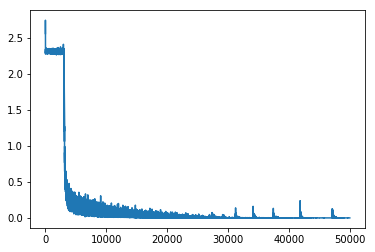

In [4]:
#Training for Convolution Layers only
train_acc = []
c_ent = []

for i in trange(50000): 
    batch_x, batch_y = mnist.train.next_batch(100)
    _,curr_loss,acc = sess.run([train_step,cross_entropy,accuracy], feed_dict={x: batch_x, y_actual: batch_y})
    c_ent.append(curr_loss)
    
    if i%1000 == 0:
        train_acc.append(acc)

plt.plot(c_ent)


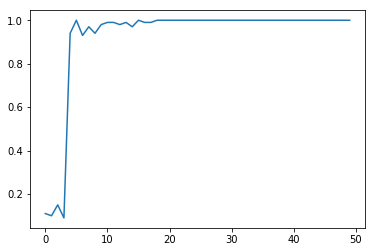

In [5]:
plt.plot(train_acc)

In [6]:
#Final Validation Set Accuracy for just Convolution Layers
curr_acc = sess.run(accuracy, feed_dict={x: mnist.test.images, y_actual: mnist.test.labels})
print("Final Accuracy with Convolutional Layers: " + str(curr_acc))

sess.close()

Final Accuracy with Convolutional Layers: 0.9791


    b) Calculate the receptive field of your 2-layer CNN for a 28x28 MNIST image.
   
The receptive field is determined by the equation $r_n=r_p+s_a*(k_n-1^n )$.  For a two layer Convolutional Network with filter size 3x3 and 1^n stride, the resulting receptive field is 5x5.

**Problem 3: Adding pooling and dropout to a 2-layer CNN with TensorFlow (24 points)**
    
To gain a better understanding of how pooling and dropout affect the performance of CNNs,
please try the following:

    a) Add 2x2 pooling layers after each convolutional layer for the specification in Problem 2.

In [7]:
#Input Image
x = tf.placeholder(tf.float32, [None, 784])
x_shaped = tf.reshape(x,[-1,28,28,1])

#1st layer
W1_cl = tf.Variable(tf.truncated_normal([3, 3, 1, 4], stddev=0.1))
B1_cl = tf.Variable(tf.zeros([4]))
conv1 = tf.nn.sigmoid( tf.nn.conv2d(x_shaped, W1_cl, strides=[1,1,1,1], padding='SAME') + B1_cl)

#Max Pooling, 1st time
max_pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

#2nd layer
W2_cl = tf.Variable(tf.truncated_normal([3, 3, 4, 8], stddev=0.1))
B2_cl = tf.Variable(tf.zeros([8]))
conv2 = tf.nn.sigmoid(tf.nn.conv2d(max_pool1, W2_cl, strides=[1,1,1,1], padding='SAME') + B2_cl)

max_pool2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

#Making a flat vector of our convolutional layers
flat_v = tf.reshape(max_pool2,[-1,7*7*8])

#1st Fully Connected Layer
W1_fc = tf.Variable(tf.truncated_normal([7*7*8,7*8], stddev=0.1))
B1_fc = tf.Variable(tf.zeros([7*8]))
Z_fc = tf.nn.sigmoid(tf.matmul(flat_v, W1_fc) + B1_fc)

#2nd Fully Connected Layer
W2_fc = tf.Variable(tf.truncated_normal([7*8,10], stddev=0.1))
B2_fc = tf.Variable(tf.zeros([10]))
Y_fc = tf.matmul(Z_fc,W2_fc) + B2_fc

#Get Softmax
soft_Y = tf.nn.softmax(Y_fc)
y_actual = tf.placeholder(tf.float32, [None, 10])
#For Training
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_actual * tf.log(soft_Y), reduction_indices=[1]))
train_step = tf.train.AdamOptimizer().minimize(cross_entropy)

#For accuracy Predictions
correct_prediction = tf.equal(tf.argmax(soft_Y, 1), tf.argmax(y_actual, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

 # Create a Session object, initialize all variables
sess = tf.Session()
sess.run(tf.global_variables_initializer())

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [02:22<00:00, 350.99it/s]


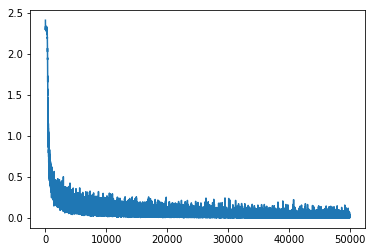

In [8]:
#Training for Added Pooling
train_acc = []
c_ent = []

for i in trange(50000): 
    batch_x, batch_y = mnist.train.next_batch(100)
    _,curr_loss,acc = sess.run([train_step,cross_entropy,accuracy], feed_dict={x: batch_x, y_actual: batch_y})
    c_ent.append(curr_loss)
    
    if i%1000 == 0:
        train_acc.append(acc)

plt.plot(c_ent)

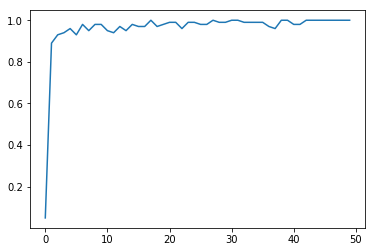

In [9]:
plt.plot(train_acc)

In [10]:
curr_acc = sess.run(accuracy, feed_dict={x: mnist.test.images, y_actual: mnist.test.labels})
print("Final Accuracy with Pooling Included: " + str(curr_acc))

sess.close()

Final Accuracy with Pooling Included: 0.9843


    b) Add dropout after the first fully connected layer for the specification in Problem 2. You
    can choose the probability of keeping (not setting to zero) hidden unit elements.

In [11]:
#Input Image
x = tf.placeholder(tf.float32, [None, 784])
x_shaped = tf.reshape(x,[-1,28,28,1])

#1st layer
W1_cl = tf.Variable(tf.truncated_normal([3, 3, 1, 4], stddev=0.1))
B1_cl = tf.Variable(tf.zeros([4]))
conv1 = tf.nn.sigmoid( tf.nn.conv2d(x_shaped, W1_cl, strides=[1,1,1,1], padding='SAME') + B1_cl)

#Max Pooling, 1st time
max_pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

#2nd layer
W2_cl = tf.Variable(tf.truncated_normal([3, 3, 4, 8], stddev=0.1))
B2_cl = tf.Variable(tf.zeros([8]))
conv2 = tf.nn.sigmoid(tf.nn.conv2d(max_pool1, W2_cl, strides=[1,1,1,1], padding='SAME') + B2_cl)

max_pool2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

#Making a flat vector of our convolutional layers
flat_v = tf.reshape(max_pool2,[-1,7*7*8])

#1st Fully Connected Layer
W1_fc = tf.Variable(tf.truncated_normal([7*7*8,7*8], stddev=0.1))
B1_fc = tf.Variable(tf.zeros([7*8]))
Z_fc = tf.nn.sigmoid(tf.matmul(flat_v, W1_fc) + B1_fc)

fc_dropout = tf.nn.dropout(Z_fc, keep_prob=0.75, name='dropout')

#2nd Fully Connected Layer
W2_fc = tf.Variable(tf.truncated_normal([7*8,10], stddev=0.1))
B2_fc = tf.Variable(tf.zeros([10]))
Y_fc = tf.matmul(Z_fc,W2_fc) + B2_fc

#Get Softmax
soft_Y = tf.nn.softmax(Y_fc)
y_actual = tf.placeholder(tf.float32, [None, 10])
#For Training
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_actual * tf.log(soft_Y), reduction_indices=[1]))
train_step = tf.train.AdamOptimizer().minimize(cross_entropy)

#For accuracy Predictions
correct_prediction = tf.equal(tf.argmax(soft_Y, 1), tf.argmax(y_actual, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

 # Create a Session object, initialize all variables
sess = tf.Session()
sess.run(tf.global_variables_initializer())

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [02:30<00:00, 331.76it/s]


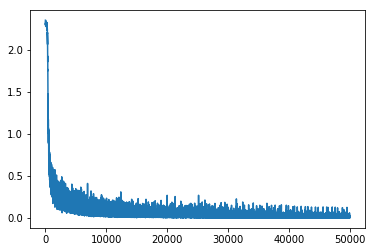

In [12]:
#Training with dropout
train_acc = []
c_ent = []

for i in trange(50000): 
    batch_x, batch_y = mnist.train.next_batch(100)
    _,curr_loss,acc = sess.run([train_step,cross_entropy,accuracy], feed_dict={x: batch_x, y_actual: batch_y})
    c_ent.append(curr_loss)
    
    if i%1000 == 0:
        train_acc.append(acc)

plt.plot(c_ent)

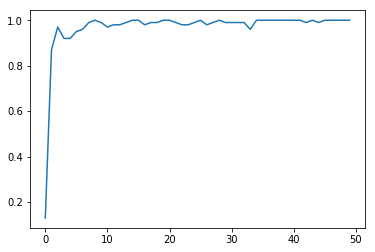

In [13]:
plt.plot(train_acc)

In [14]:
curr_acc = sess.run(accuracy, feed_dict={x: mnist.test.images, y_actual: mnist.test.labels})
print("Final Accuracy with Dropout Included: " + str(curr_acc))

sess.close()

Final Accuracy with Dropout Included: 0.9846
